## Graph Data Generation (Done on Google Collab)
### Load Packages (Mout Driver At First)
### Define Data Path (Path is based on the google collab drive path, not local fs path)
### Compress Train Data With AAE
### Cluster Train Representation Data With KMeans Cluster
### Generate Complete Graph Data
### Map Train Data With Complete Graph Data For Final Training Data (train.tfr for final model training)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###1.Load Packages

In [2]:
"""Install NSL and TensorflowAddon package"""
!pip install --upgrade neural_structured_learning
!pip install tensorflow-addons

     |████████████████████████████████| 122kB 4.8MB/s 
     |████████████████████████████████| 706kB 5.5MB/s 


In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from neural_structured_learning.tools import graph_utils
import neural_structured_learning as nsl
import tensorflow_addons as tfa
from copy import deepcopy
from sklearn.metrics import multilabel_confusion_matrix
import random
import os
import PIL
import time
import re

tf.keras.backend.clear_session()
print("tensorflow version: ", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.experimental.list_physical_devices('GPU') else "NOT AVAILABLE")

tensorflow version:  2.4.1
keras version 2.4.0
Eager mode:  True
GPU is available


In [4]:
from graph_data_processing import GraphDataProcess
from AAE_model import AAE
from nsl_data_processing import GenerateTrainTestDict, NSLDataFormat
from Kmeans import KMeans, KMeansModels

###2.Define Data Path

In [17]:
''' label definition: NonDemented - 0, VeryMildDemented - 1, MildDemented -2, ModerateDemented -3 '''
label_list = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
root_path = '/content/drive/MyDrive/AD Expriment II/graph_images/'
train_root_path = f'{root_path}train/'
test_root_path = f'{root_path}test/'

train_path_list = [f'{train_root_path}{label}/' for label in label_list]
train_tfr_list = [f'{train_root_path}{label}.tfr' for label in label_list]

test_path_list = [f'{test_root_path}{label}/' for label in label_list]
test_tfr_list = [f'{test_root_path}{label}.tfr' for label in label_list]

tfr_rep_list = [f'{train_root_path}{label}_AAErep.tfr' for label in label_list]

train_tfr_path = f'{train_root_path}train_data.tfr'

###3.Compress TRAIN data with AAE

In [6]:
'''Generate AAE represents'''
latent_dim = 128
learning_rate = 0.0001
channels = 3
real_mean = 0
real_std = 1
batch = 1
size=(100, 100)
epochs= 100
checkpoint_path = '/content/drive/MyDrive/AD Expriment II/AAE_model_checkpoints/aae_model_checkpoints'
image_dataset = GraphDataProcess.parse_tfr_to_image_tensor(path_list=train_tfr_list, 
                                                           batch_size=batch, 
                                                           size= size, 
                                                           channels= channels, 
                                                           shuffle=True)
aae = AAE(latent_dim=latent_dim, 
          image_channels=channels,
          aae_optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, amsgrad=True))
aae.load_weights(checkpoint_path)           # NOTE: checkpoints are too big to uploaded to the git repo, so this line could be commented out in the first run

In [ ]:
aae.fit(image_dataset=image_dataset,
        checkpoints_path=checkpoint_path,
        batch_size=1,
        real_mean=real_mean,
        real_std=real_std,
        epochs=epochs,)

epoch:  1, epoch_time: 89.97340, total_loss: 2.42051, discriminator_loss: 1.38967, generator_loss: 0.69123, reconstruction_loss: 0.33961
epoch:  2, epoch_time: 88.10334, total_loss: 2.42498, discriminator_loss: 1.39144, generator_loss: 0.69441, reconstruction_loss: 0.33913
epoch:  3, epoch_time: 87.62231, total_loss: 2.41903, discriminator_loss: 1.39052, generator_loss: 0.68972, reconstruction_loss: 0.33879
epoch:  4, epoch_time: 87.51085, total_loss: 2.42023, discriminator_loss: 1.38945, generator_loss: 0.69228, reconstruction_loss: 0.33849
epoch:  5, epoch_time: 87.74254, total_loss: 2.41904, discriminator_loss: 1.38923, generator_loss: 0.69184, reconstruction_loss: 0.33798
epoch:  6, epoch_time: 87.33718, total_loss: 2.41872, discriminator_loss: 1.38879, generator_loss: 0.69236, reconstruction_loss: 0.33756
epoch:  7, epoch_time: 87.50143, total_loss: 2.41871, discriminator_loss: 1.38902, generator_loss: 0.69239, reconstruction_loss: 0.33730
epoch:  8, epoch_time: 87.11908, total_lo

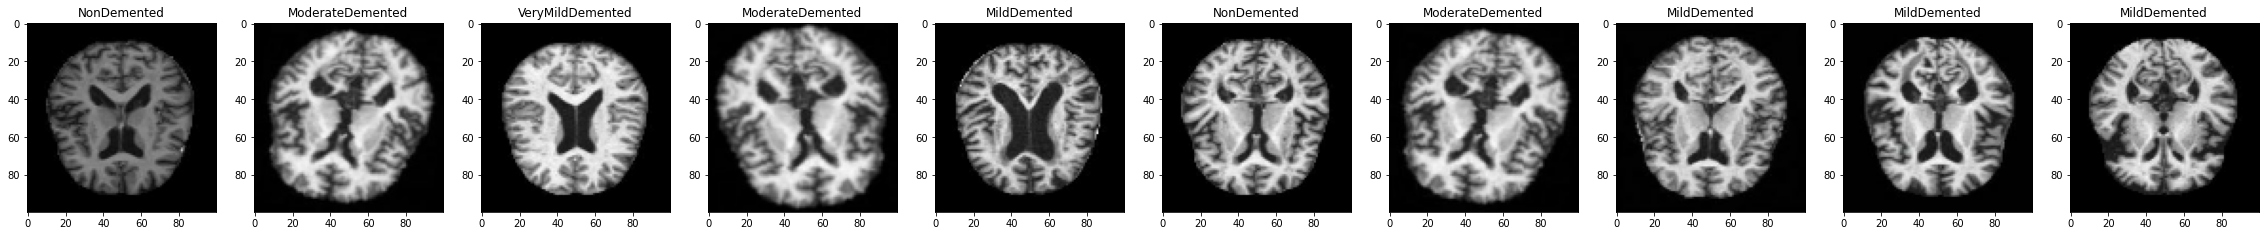

In [9]:
'''Plot real images vs reconstructed images'''
tfr_list = [f'{train_root_path}{label}.tfr' for label in label_list]
image_dataset = GraphDataProcess.parse_tfr_to_image_tensor(path_list=train_tfr_list, 
                                                           batch_size=10, 
                                                           size=(100,100),
                                                           channels=3,
                                                           shuffle=True)
data = iter(image_dataset).get_next()
plt.figure(figsize=(40,50))
for img_index, img_tensor in enumerate(data['image_tensor']):
    plt.subplot(1, 10, img_index + 1)
    plt.imshow(img_tensor)
    plt.title(label_list[data['label'].numpy()[img_index]])

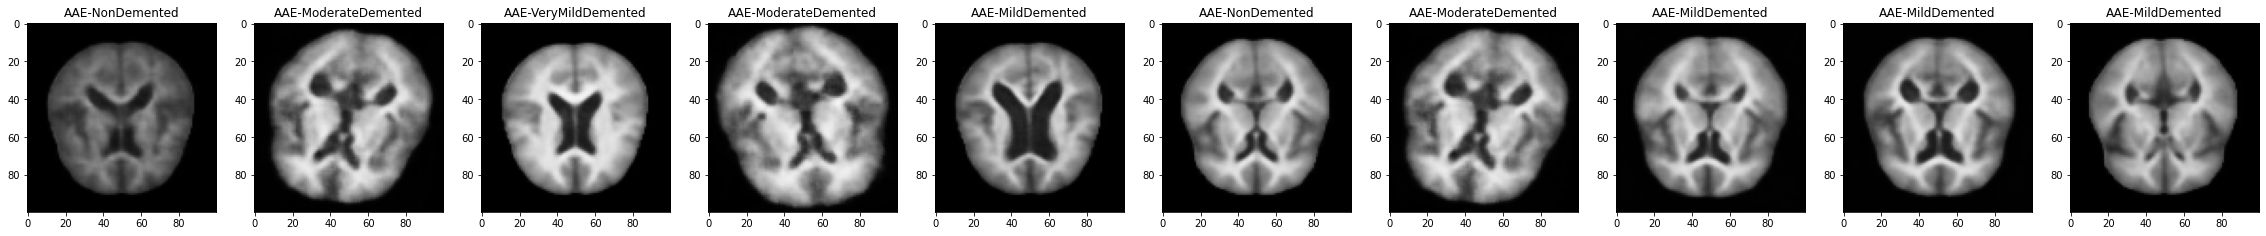

In [10]:
plt.figure(figsize=(40,50))
for img_index, img_tensor in enumerate(data['image_tensor']):
    img_tensor = tf.expand_dims(img_tensor, axis=0)
    _m, _l, rep = aae.encoder(img_tensor)
    img_new = aae.decoder(rep)
    img_new = tf.squeeze(img_new, axis=0)
    plt.subplot(1, 10, img_index + 1)
    plt.imshow(tf.abs(img_new))
    plt.title('AAE-'+label_list[data['label'].numpy()[img_index]])

In [10]:
'''generate TRAIN image represents tfr files'''
img_data_list = [ GraphDataProcess.parse_tfr_to_image_tensor(path_list=[tfr_path], batch_size=1, size=(100,100), channels=3, shuffle=False) for tfr_path in train_tfr_list]
print(*img_data_list,sep='\n')
GraphDataProcess.generate_tfr_aae_represent(image_dataset_list=img_data_list, aae_model=aae, tfr_rep_path=tfr_rep_list)     

<BatchDataset shapes: {id: (None,), label: (None,), image_tensor: (None, 100, 100, 3)}, types: {id: tf.string, label: tf.int64, image_tensor: tf.float32}>
<BatchDataset shapes: {id: (None,), label: (None,), image_tensor: (None, 100, 100, 3)}, types: {id: tf.string, label: tf.int64, image_tensor: tf.float32}>
<BatchDataset shapes: {id: (None,), label: (None,), image_tensor: (None, 100, 100, 3)}, types: {id: tf.string, label: tf.int64, image_tensor: tf.float32}>
<BatchDataset shapes: {id: (None,), label: (None,), image_tensor: (None, 100, 100, 3)}, types: {id: tf.string, label: tf.int64, image_tensor: tf.float32}>


###4.Cluster AAE Represents

In [13]:
"""generate K_means models for each label data"""
batch= 5000
rep_dim= 128
K_value_list = [10, 10, 10, 10]
epoch= 50
Kmeans_model_list = KMeansModels.generate_model_list(path_list = tfr_rep_list, rep_dim=rep_dim, K_list=K_value_list, epoch=epoch, batch=batch)


====================== Model 0 training ======================

epoch:  1 ,centroid mean:  0.00035726876
epoch:  2 ,centroid mean:  0.015676854
epoch:  3 ,centroid mean:  0.02288131
epoch:  4 ,centroid mean:  0.03229449
epoch:  5 ,centroid mean:  0.040147275
epoch:  6 ,centroid mean:  0.047732033
epoch:  7 ,centroid mean:  0.051580083
epoch:  8 ,centroid mean:  0.056514375
epoch:  9 ,centroid mean:  0.059387617
epoch:  10 ,centroid mean:  0.061140478
epoch:  11 ,centroid mean:  0.06321819
epoch:  12 ,centroid mean:  0.06670548
epoch:  13 ,centroid mean:  0.06938274
epoch:  14 ,centroid mean:  0.07097573
epoch:  15 ,centroid mean:  0.071791016
epoch:  16 ,centroid mean:  0.07159651
epoch:  17 ,centroid mean:  0.07119917
epoch:  18 ,centroid mean:  0.07049733
epoch:  19 ,centroid mean:  0.07035604
epoch:  20 ,centroid mean:  0.07020301
epoch:  21 ,centroid mean:  0.070182964
epoch:  22 ,centroid mean:  0.070185386
epoch:  23 ,centroid mean:  0.070161015
epoch:  24 ,centroid mean:  0.070

###5.Generate TRAIN Graph data based on clustering

In [14]:
'''generate the complete graph with clustering for TRAIN data only'''
threshold = 0.95
complete_graph = GraphDataProcess.generate_complete_graph_with_cluster_kmeans(tfr_rep_path_list= tfr_rep_list,
                                                                              prefix_list= [0,1,2,3],
                                                                              model_list= Kmeans_model_list, 
                                                                              represent_dim= 128,
                                                                              file_output_path= f'{train_root_path}AD_graph_AAE_KMeans.tsv',
                                                                              similarity_threshold=threshold)
complete_graph

Output hidden; open in https://colab.research.google.com to view.

In [15]:
"""count seed node number for each label"""
seed_count={}
for key in complete_graph.keys():
    split_content = key.split('_')[0]
    if 'c' not in split_content: 
        index=int(split_content)
        if index in [0,1,2,3] and (index in seed_count):
            seed_count[index] +=1
        elif index in [0,1,2,3] and (index not in seed_count):
            seed_count[index] =1
print(seed_count)

{0: 2559, 1: 2544, 2: 2555, 3: 2558}


###6.Generate NSL compatible training data (train.tfr)

In [16]:
'''Generate the TRAIN dictionary with shuffled MRI images'''
train_examples, _ = GenerateTrainTestDict.get_train_test_dict(path_list=train_path_list, train_percentage=1)
print('train examples: ', len(train_examples.keys()))

train examples:  10255


In [18]:
'''generate "train_data.tfr" by merging TRAIN examples with the complete AAE graph'''
nsl_train= NSLDataFormat(seed_dict_examples= train_examples,
                         rem_dict_examples= _, 
                         graph= nsl.tools.read_tsv_graph(f'{train_root_path}AD_graph_AAE_KMeans.tsv'), 
                         max_nbrs= 5)
nsl_train.generate_node_nbrs_tfr(output_file_path=train_tfr_path)              #NOTE: train_data.tfr is uploaded to git repo, so this cell could be commented out

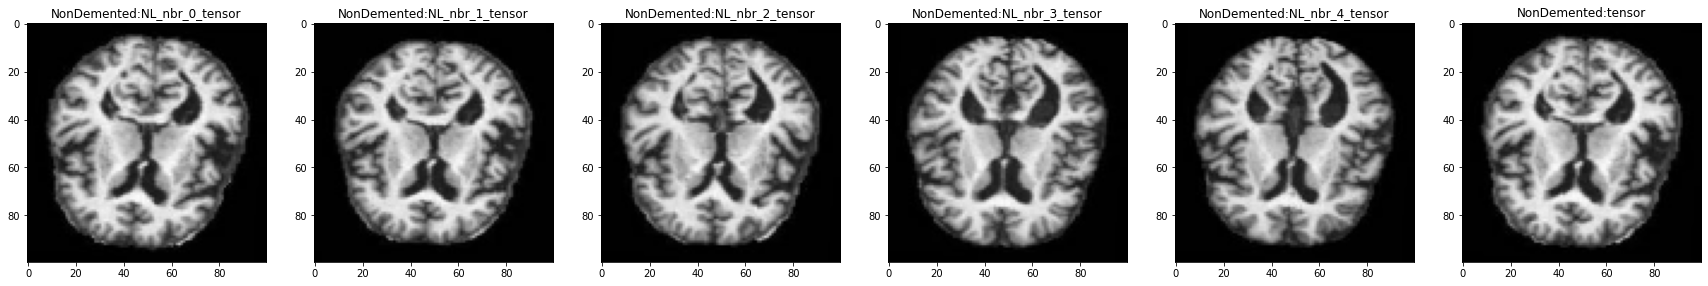

In [19]:
'''parse train_graph_examples with clusters'''
parsed_image_size=(100,100)
parsed_image_channel=3
batch=1
max_seed_node_neighbours=5
train_image_dataset = NSLDataFormat.parse_tfr_to_dataset(file_path_list=[train_tfr_path],
                                                   batch_size=batch,
                                                   max_neighbor_number= max_seed_node_neighbours,
                                                   image_size=parsed_image_size,
                                                   image_channels=parsed_image_channel,
                                                   shuffle=True)
data_sample = iter(train_image_dataset).get_next()

'''plot parsed train_graph examples with clusters'''
label =  tf.argmax(data_sample[1], axis=0)
sample = data_sample[0]
img_index=0
plt.figure(figsize=(30,10))
for key, value in sample.items():
    if key.split('_')[-1]=='tensor':
        plt.subplot(1,max_seed_node_neighbours+1,img_index + 1)
        img_tensor = tf.reshape(value, shape=value.shape[1:])
        plt.imshow(img_tensor)
        plt.title(f'{label_list[label.numpy()[0]]}:{key}')
        img_index +=1